In [1]:
import os
import numpy as np
import cv2 # OpenCV
from sklearn.svm import SVC # SVM klasifikator
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier # KNN
from joblib import dump, load
import matplotlib
import matplotlib.pyplot as plt
import sys

from imutils import face_utils
import argparse
import imutils
import dlib

%matplotlib inline

In [2]:
# inicijalizaclija dlib detektora (HOG)
detector = dlib.get_frontal_face_detector()
# ucitavanje pretreniranog modela za prepoznavanje karakteristicnih tacaka
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

In [3]:
def overlay_image_alpha(img, img_overlay, pos, alpha_mask):
    """Overlay img_overlay on top of img at the position specified by
    pos and blend using alpha_mask.

    Alpha mask must contain values within the range [0, 1] and be the
    same size as img_overlay.
    """

    x, y = pos

    # Image ranges
    y1, y2 = max(0, y), min(img.shape[0], y + img_overlay.shape[0])
    x1, x2 = max(0, x), min(img.shape[1], x + img_overlay.shape[1])

    # Overlay ranges
    y1o, y2o = max(0, -y), min(img_overlay.shape[0], img.shape[0] - y)
    x1o, x2o = max(0, -x), min(img_overlay.shape[1], img.shape[1] - x)

    # Exit if nothing to do
    if y1 >= y2 or x1 >= x2 or y1o >= y2o or x1o >= x2o:
        return

    channels = img.shape[2]

    alpha = alpha_mask[y1o:y2o, x1o:x2o]
    alpha_inv = 1.0 - alpha

    for c in range(channels):
        img[y1:y2, x1:x2, c] = (alpha * img_overlay[y1o:y2o, x1o:x2o, c] +
                                alpha_inv * img[y1:y2, x1:x2, c])

In [20]:
def put_mask_on_face(face_image):
    
    gray = cv2.cvtColor(face_image, cv2.COLOR_BGR2GRAY)

    rects = detector(gray, 1)
    mask = cv2.imread('mask.png')
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

    for (b, rect) in enumerate(rects):

        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape) # konverzija u NumPy niz

        (i,j)=face_utils.FACIAL_LANDMARKS_IDXS.get('jaw')
        (x, y, w, h) = cv2.boundingRect(np.array([shape[i:j]]))
        roi = gray[y:y + h, x:x + w]

        resized_mask = cv2.resize(mask,(roi.shape[1]+15,roi.shape[0]-20))
        overlay_image_alpha(face_image,
                            resized_mask[:, :, 0:3],
                             (x-10, y+15),
                            resized_mask[:, :, 2] / 255.0)
    
    return face_image

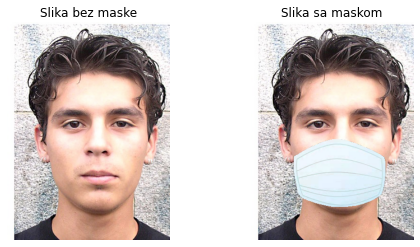

In [21]:
img = cv2.cvtColor(cv2.imread('dataset/without_mask/309.jpg'), cv2.COLOR_BGR2RGB)
image = cv2.cvtColor(cv2.imread('dataset/without_mask/309.jpg'), cv2.COLOR_BGR2RGB)

mask_face=put_mask_on_face(img)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image)
ax1.set_title('Slika bez maske')


ax2.axis('off')
ax2.imshow(mask_face)
ax2.set_title('Slika sa maskom')
plt.show()

# for filename in os.listdir('dataset/without_mask'):
#     img = cv2.imread('dataset/without_mask/'+ filename)
#     mask_face=put_mask_on_face(img)

#     cv2.imwrite('dataset/with_mask1/' + filename, mask_face)
